# Thermostatic Control - Max Start-ups with explicit state

Here we make and enviroment like the bang-bang controller prior, but with a limit on the number of times it can start up in a given window.  For completeness, here are the features of this environment:

- Has a response time constant tau that dictates how fast the system responds to heater on/off states.
- Keeps track of how many times it has turned on in a past window of time, and limits it, otherwise, we consider it a failure.  The idea is that toggling on too many times will damage/break equipment, and we model that here.
- We also expose the 'number of startups left in window' as a state parameter.

To this end, the most complicated code exposed here is that of creating an environment that will correctly model the "fail if it starts too many times".

A point of emphasis here is on hitting the failure condition while training.  Depending on the circumstances, failure while training can be either cheap or expensive.  When training RL to win at "Go", many millions of games were played, and games that were lost provided some of the signal for learning a winning policy.  But those game losses were cheap -- nothing broke and no one was harmed.  However, learning policies in industrial settings or health care can be expensive or dangerous to people.  A sub-optimal policy in the midst of training is sub-optimal because it will make a bad decision that can cause harm to a machine or person.  This means that during training, episodes that terminate in failure are expensive.  Here we make a model to give us insight into this phenomenon.

# Set up the environment

Here we code the environment class to use.  It will include logic that terminates an episode before it reaches its `max_timestep` limit.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorforce.environments import Environment
from tensorforce.agents import Agent

In [103]:
class ThermostatEnvironment(Environment):
    
    def __init__(self):
        ## Some initializations.  Will eventually parameterize this in the constructor.
        self.tau = 3.0
        self.current_temp = 0.0
        self.timestep = 0
        self.max_timestep = 100
        self.exceed_toggle_on_reward = -1.0
        
        ## Heater on states
        self.last_heater_state = 0
        self.max_toggle_ons = 3 # max number of times you can turn heater on...
        self.toggle_ons_left = self.max_toggle_ons # Track toggle ons left in window
        self.window_toggle_ons = 20 # Window of time over which you can use your max_toggle_ons
        self.off_to_on = [] # timesteps at which state went off to on
    
        super().__init__()

    def states(self):
        """Two state components:
               1. current_temp
               2. toggle_ons_left
        """
        return dict(type='float', shape=(2,))

    def actions(self):
        return dict(type='int', num_values=2)

    # Optional, should only be defined if environment has a natural maximum
    # episode length
    def max_episode_timesteps(self):
        # return super().max_episode_timesteps()
        return self.max_timestep

    # Optional
    def close(self):
        super().close()

    def reset(self):
        self.timestep = 0
        self.last_heater_state = 0
        self.off_to_on = []
        self.toggle_ons_left = self.max_toggle_ons
        self.current_temp = np.random.random(size=(1,))
        return np.array([self.current_temp, self.toggle_ons_left], dtype=np.float)

    def response(self, action):
        """Respond to an action.  When the action is 1, the temperature
        exponentially decays approaches 1.0.  When the action is 0,
        the current temperature decays towards 0.0.
        """
        return action + (self.current_temp - action) * math.exp(-1.0 / self.tau)

    def reward_compute(self):
        """ The reward here is 0 if the current temp is between 0.4 and 0.6,
        else it is distance the temp is away from the 0.4 or 0.6 boundary.
        """
        delta = abs(self.current_temp - 0.5)
        if delta < 0.1:
            return 0.0
        else:
            return -delta[0] + 0.1

    def execute(self, actions):
        ## Check the action is either 0 or 1 -- heater on or off.
        assert actions == 0 or actions == 1

        ## Increment timestamp
        self.timestep += 1
        
        ## Update the current_temp
        self.current_temp = self.response(actions)

        ## Update off_to_ons if necessary
        if actions == 1 and self.last_heater_state == 0:
            self.off_to_on += [self.timestep]
            
        ## Update last heater state to current state
        self.last_heater_state = actions
        
        ## Check if we have violated max_startups, return as necessary
        ## Make a list of the events within the window
        lstWindowEvents = [e for e in self.off_to_on
                              if self.timestep - e <= self.window_toggle_ons]

        ## Calculate number of toggle_ons_left
        self.toggle_ons_left = self.max_toggle_ons - len(lstWindowEvents)
        
        ## Conditional returns
        ##
        ## If we have done too many startups, end episode, return big penalty
        if self.toggle_ons_left < 0:
            return np.array([self.current_temp, self.toggle_ons_left], dtype=np.float), True, self.exceed_toggle_on_reward
        
        ## If we exceed max_timestamps, end episode.
        if self.timestep > self.max_episode_timesteps():
            return np.array([self.current_temp, self.toggle_ons_left], dtype=np.float), True, self.reward_compute()
        
        ## Default return
        return np.array([self.current_temp, self.toggle_ons_left], dtype=np.float), False, self.reward_compute()

## Instantiate environment object
# environment = ThermostatEnvironment()
environment = environment = Environment.create(
    environment=ThermostatEnvironment,
    max_episode_timesteps=100)

In [104]:
## Initialize
## Test the environment does what I expect it to
print(environment.reset())

print(environment.execute(1))
print(environment.execute(0))
print(environment.execute(1))
print(environment.execute(0))
print(environment.execute(1))
print(environment.execute(0))
print(environment.execute(1))
print(environment.execute(1))
print(environment.execute(1))
print(environment.environment.off_to_on)
print(environment.timestep)
print(environment.environment.timestep)

[0.1607622 3.       ]
(array([0.39865984, 2.        ]), 0, -0.0013401619951956822)
(array([0.28565226, 2.        ]), 0, -0.11434774380128301)
(array([0.48814747, 1.        ]), 0, 0.0)
(array([0.34977295, 1.        ]), 0, -0.05022705003609765)
(array([0.53409196, 0.        ]), 0, 0.0)
(array([0.38269361, 0.        ]), 0, -0.01730638817280508)
(array([ 0.55768064, -1.        ]), 1, -1.0)
(array([ 0.68306433, -1.        ]), 1, -1.0)
(array([ 0.77290567, -1.        ]), 1, -1.0)
[1, 3, 5, 7]
9
9


In [105]:
## Agent setup
agent = Agent.create(
    agent='tensorforce', environment=environment, update=32,
    objective='policy_gradient', reward_estimation=dict(horizon=25)
)

## Agent setup
# agent = Agent.create(
#     agent='ppo', environment=environment, batch_size=20, learning_rate=1e-3,
#     exploration=0.1
# )


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
# Train
for _ in range(10000):
    states = environment.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        #print(f"{states}, {terminal}, {reward}")
        agent.observe(terminal=terminal, reward=reward)

[0.43831554 3.        ]
[1, 4, 6, 9]


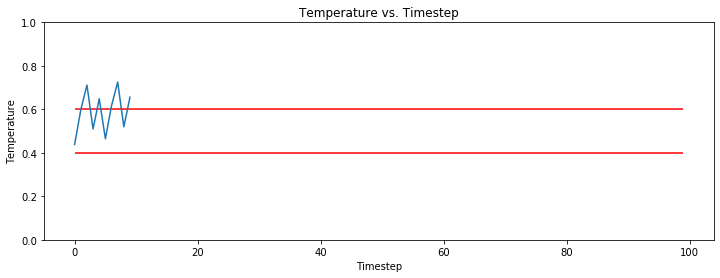

In [124]:
### Initialize
print(environment.reset())

## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## In order to alter the attributes of your instance of the original
## class, like to set the initial temp to a custom value, like here,
## you need to access the `environment` member of this wrapped class.
## That is why you see the way to set the current_temp like below.
# environment.environment.current_temp = np.array([1.0])
# states = environment.environment.current_temp

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.environment.current_temp[0]]
while not terminal:
    actions, internals = agent.act(states=states, internals=internals, evaluation=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]

# print(temp)
print(environment.environment.off_to_on)

### Plot the run
plt.figure(figsize=(12, 4))
ax=plt.subplot()
ax.set_ylim([0.0, 1.0])
plt.plot(range(len(temp)), temp)
plt.hlines(y=0.4, xmin=0, xmax=99, color='r')
plt.hlines(y=0.6, xmin=0, xmax=99, color='r')
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.title('Temperature vs. Timestep')
plt.show()